In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..', 'bball_code'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append('/Users/drewadamski/Desktop/capstone-one-master/Update/Data')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, confusion_matrix,
                             precision_recall_curve, roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from statsmodels.stats import weightstats

sns.set()

In [71]:
df = pd.read_csv(sys.path[-1]+'/model_data.csv', index_col=0)
df.shape

(6693, 42)

In [72]:
df_2019 = df[df.season==2019].copy()
df_rest = df[df.season!=2019].copy()

In [5]:
int_df = df_rest.select_dtypes(exclude=object).copy()
int_df.drop('season', axis=1, inplace=True)
int_df[int_df['allstar_next']==0].shape,int_df[int_df['allstar_next']==1].shape

((5923, 36), (455, 36))

## Resampling Datset
Data is highly imbalanced. I wanted to try equalizing the two but the model was severely overfitting. Instead I am going to randomly downsample the outgroup from 6219 individuals to 3500. This should be a good balance where the model will learn the important features without weighing them too heavily.

In [6]:
# class0 = int_df[int_df['allstar_next']==0].copy()
# class1 = int_df[int_df['allstar_next']==1].copy()

In [7]:
# downsampled0 = class0.sample(n=3500, replace=True)
# upsampled1 = class1

In [8]:
# int_df = downsampled0.append(upsampled1)

# Building Training, Testing, and Validating Datasets

In [9]:
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target,
                                                test_size=0.3,
                                                random_state=13)


Xtest, Xval, ytest, yval = train_test_split(Xtest, ytest,
                                             stratify=ytest,
                                             test_size=0.3,
                                             random_state=13)

print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape, Xval.shape, yval.shape)

scaler = StandardScaler()

(4464, 35) (4464,) (1339, 35) (1339,) (575, 35) (575,)


# Random Forest

In [11]:
rfc = RandomForestClassifier(random_state=13)
rfc_pipeline = make_pipeline(scaler, rfc)

rfc_pipeline.fit(Xtrain, ytrain)
ypred_rfc = rfc_pipeline.predict(Xtest)
yprob_rfc = rfc_pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred_rfc))
print(classification_report(ytest, ypred_rfc))

fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(ytest, yprob_rfc[:,1])
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

yprob_rfc = yprob_rfc[:, 1]
precision_rfc, recall_rfc, thresholds_rfc = precision_recall_curve(ytest, yprob_rfc)
pr_auc_rfc = auc(recall_rfc, precision_rfc)

[[1230   13]
 [  54   42]]
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1243
         1.0       0.76      0.44      0.56        96

    accuracy                           0.95      1339
   macro avg       0.86      0.71      0.76      1339
weighted avg       0.94      0.95      0.94      1339



# Logistic Regression

In [12]:
lr = LogisticRegression(random_state=13)
lr_pipeline = make_pipeline(scaler, lr)

lr_pipeline.fit(Xtrain, ytrain)
ypred_lr = lr_pipeline.predict(Xtest)
yprob_lr = lr_pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred_lr))
print(classification_report(ytest, ypred_lr))

fpr_lr, tpr_lr, threshold_lr = roc_curve(ytest, yprob_lr[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

yprob_lr = yprob_lr[:, 1]
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(ytest, yprob_lr)
pr_auc_lr = auc(recall_lr, precision_lr)

[[1220   23]
 [  45   51]]
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1243
         1.0       0.69      0.53      0.60        96

    accuracy                           0.95      1339
   macro avg       0.83      0.76      0.79      1339
weighted avg       0.94      0.95      0.95      1339



# Support Vector Machine

In [13]:
svm = SVC(probability=True, random_state=13)

svm_pipeline = make_pipeline(scaler, svm)

svm_pipeline.fit(Xtrain, ytrain)
ypred_svm = svm_pipeline.predict(Xtest)
yprob_svm = svm_pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred_svm))
print(classification_report(ytest, ypred_svm))

fpr_svm, tpr_svm, threshold_svm = roc_curve(ytest, yprob_svm[:,1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

yprob_svm = yprob_svm[:, 1]
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(ytest, yprob_svm)
pr_auc_svm = auc(recall_svm, precision_svm)

[[1224   19]
 [  42   54]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1243
         1.0       0.74      0.56      0.64        96

    accuracy                           0.95      1339
   macro avg       0.85      0.77      0.81      1339
weighted avg       0.95      0.95      0.95      1339



# K Nearest Neighbors

In [15]:
knc = KNeighborsClassifier()

knc_pipeline = make_pipeline(scaler, knc)

knc_pipeline.fit(Xtrain, ytrain)
ypred_knc = knc_pipeline.predict(Xtest)
yprob_knc = knc_pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred_knc))
print(classification_report(ytest, ypred_knc))

fpr_knc, tpr_knc, threshold_knc = roc_curve(ytest, yprob_knc[:,1])
roc_auc_knc = auc(fpr_knc, tpr_knc)

yprob_knc = yprob_knc[:, 1]
precision_knc, recall_knc, thresholds_knc = precision_recall_curve(ytest, yprob_knc)
pr_auc_knc = auc(recall_knc, precision_knc)

[[1218   25]
 [  42   54]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1243
         1.0       0.68      0.56      0.62        96

    accuracy                           0.95      1339
   macro avg       0.83      0.77      0.80      1339
weighted avg       0.95      0.95      0.95      1339



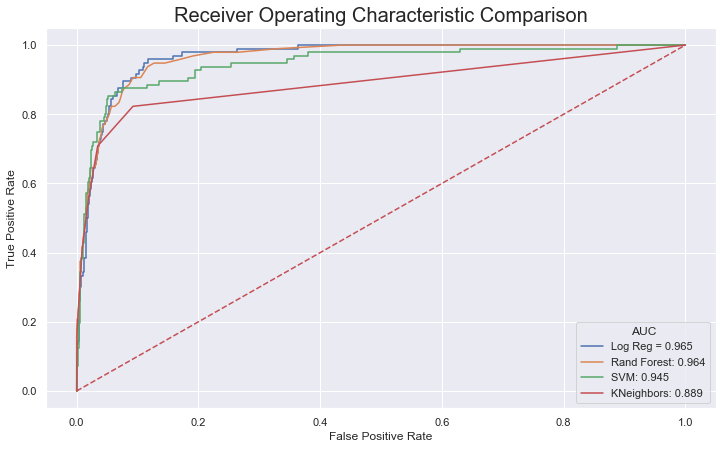

In [16]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Receiver Operating Characteristic Comparison', size=20)
_ = plt.plot(fpr_lr, tpr_lr, label = 'Log Reg = %0.3f' % roc_auc_lr)
_ = plt.plot(fpr_rfc, tpr_rfc, label='Rand Forest: %0.3f' % roc_auc_rfc)
_ = plt.plot(fpr_svm, tpr_svm, label='SVM: %0.3f' % roc_auc_svm)
_ = plt.plot(fpr_knc, tpr_knc, label='KNeighbors: %0.3f' % roc_auc_knc)
_ = plt.legend(title='AUC', loc = 'lower right')
_ = plt.plot([0, 1], [0, 1],'r--')
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')
_ = plt.show()

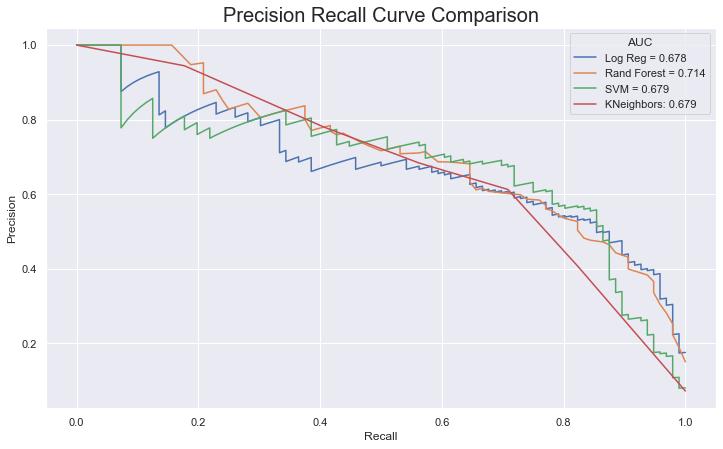

In [17]:
plt.figure(figsize=(12,7));
plt.title('Precision Recall Curve Comparison', size=20);
plt.plot(recall_lr, precision_lr, label = 'Log Reg = %0.3f' % pr_auc_lr);
plt.plot(recall_rfc, precision_rfc, label = 'Rand Forest = %0.3f' % pr_auc_rfc);
plt.plot(recall_svm, precision_svm, label = 'SVM = %0.3f' % pr_auc_svm);
plt.plot(recall_knc, precision_knc, label = 'KNeighbors: %0.3f' % pr_auc_knc);
plt.ylabel('Precision');
plt.xlabel('Recall');
plt.legend(title='AUC')
plt.show();

In [18]:
model_names = ['Log Reg', 'Rand Forest', 'SVM', 'KNeighbors']
model_preds = [ypred_lr, ypred_rfc, ypred_svm, ypred_knc]
model_recalls = [classification_report(ytest, i, output_dict=True)['1.0']['recall'] for i in model_preds]

Log Reg : 0.531
Rand Forest : 0.438
SVM : 0.562
KNeighbors : 0.562


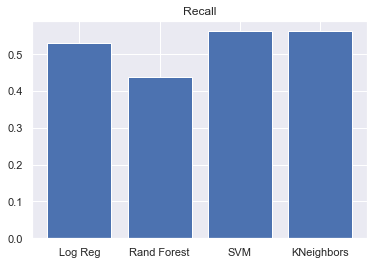

In [19]:
for i in range(4):
    print('{} : {}'.format(model_names[i], round(model_recalls[i], 3)))
_ = plt.bar(['Log Reg', 'Rand Forest', 'SVM', 'KNeighbors'], model_recalls)
_ = plt.title('Recall')

In [20]:
skb = SelectKBest(mutual_info_classif, k=features.shape[1])
skb.fit(Xtrain, ytrain)
mask = skb.get_support()
kbestfeat = list()

for boolean, feature in zip(mask, int_df.columns):
    if boolean:
        kbestfeat.append(feature)

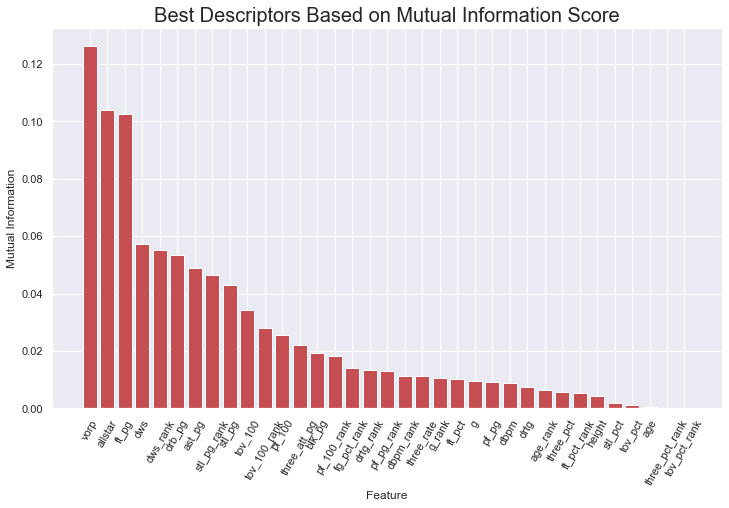

In [21]:
indices = np.argsort(skb.scores_)[::-1]
cols = []
for i in range(35):
    cols.append(features.columns[indices[i]])

# Now plot
plt.figure(figsize=[12,7])
plt.bar(cols, skb.scores_[indices[range(35)]], color='r', align='center')
plt.xticks(rotation=60)
plt.title('Best Descriptors Based on Mutual Information Score', size=20)
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.show()

# Deeper look into SVM and K Nearest Neighbor

In [22]:
knc_full_pipeline = make_pipeline(scaler, 
                                 KNeighborsClassifier())
svm_full_pipeline = make_pipeline(scaler, SVC(probability=True, random_state=13))

In [23]:
param_dic_svm = {'svc__C':np.logspace(-1, 3, 5),
                 'svc__gamma':np.logspace(0, -3, 4),
                 'svc__kernel':['rbf', 'poly', 'sigmoid']
                }

param_dic_knc = {'kneighborsclassifier__n_neighbors':[5, 10, 20],
                'kneighborsclassifier__weights':['uniform', 'distance'],
                'kneighborsclassifier__algorithm':['ball_tree', 'kd_tree',
                                                   'auto'
                                                  ],
                'kneighborsclassifier__p':[1, 2, 4]
               }

In [23]:
param_dic_svm = {'svc__C':np.logspace(-1, 3, 5),
                 'svc__gamma':np.logspace(0, -3, 4),
                 'svc__kernel':['rbf', 'poly', 'sigmoid']
                }

param_dic_knc = {'kneighborsclassifier__n_neighbors':[5, 10, 20],
                'kneighborsclassifier__weights':['uniform', 'distance'],
                'kneighborsclassifier__algorithm':['ball_tree', 'kd_tree',
                                                   'auto'
                                                  ],
                'kneighborsclassifier__p':[1, 2, 4]
               }

In [24]:
gscv_knc = GridSearchCV(knc_full_pipeline, param_dic_knc, verbose=0)
gscv_knc.fit(Xtrain, ytrain)
print(gscv_knc.best_estimator_)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=10, p=1,
                                      weights='distance'))],
         verbose=False)


In [25]:
gscv_pred_knc = gscv_knc.predict(Xtest)
gscv_prob_knc = gscv_knc.predict_proba(Xtest)
print(confusion_matrix(ytest,gscv_pred_knc))
print(classification_report(ytest,gscv_pred_knc))

[[1223   20]
 [  48   48]]
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1243
         1.0       0.71      0.50      0.59        96

    accuracy                           0.95      1339
   macro avg       0.83      0.74      0.78      1339
weighted avg       0.94      0.95      0.95      1339



In [26]:
gscv_svm = GridSearchCV(svm_full_pipeline, param_dic_svm, verbose=2)
gscv_svm.fit(Xtrain, ytrain)
print(gscv_svm.best_estimator_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf, total=   3.4s
[CV] svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ...... svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf, total=   3.4s
[CV] svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf .....................
[CV] ...... svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf, total=   3.3s
[CV] svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf .....................
[CV] ...... svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf, total=   3.4s
[CV] svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf .....................
[CV] ...... svc__C=0.1, svc__gamma=1.0, svc__kernel=rbf, total=   3.3s
[CV] svc__C=0.1, svc__gamma=1.0, svc__kernel=poly ....................
[CV] ..... svc__C=0.1, svc__gamma=1.0, svc__kernel=poly, total=   0.8s
[CV] svc__C=0.1, svc__gamma=1.0, svc__kernel=poly ....................
[CV] ..... svc__C=0.1, svc__gamma=1.0, svc__kernel=poly, total=   0.8s
[CV] svc__C=0.1, svc__gamma=1.0, svc__kernel=poly ....................
[CV] ..... svc__C=0.1, svc__gamma=1.0, svc__kernel=poly, total=   0.8s
[CV] svc__C=0.1, svc__gamma=1.0, svc__kernel=poly ....................
[CV] .

[CV]  svc__C=0.1, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.4s
[CV] svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf .....................
[CV] ...... svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.6s
[CV] svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf .....................
[CV] ...... svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.5s
[CV] svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf .....................
[CV] ...... svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.3s
[CV] svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf .....................
[CV] ...... svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.6s
[CV] svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf .....................
[CV] ...... svc__C=1.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.3s
[CV] svc__C=1.0, svc__gamma=1.0, svc__kernel=poly ....................
[CV] ..... svc__C=1.0, svc__gamma=1.0, svc__kernel=poly, total=   0.7s
[CV] svc__C=1.0, svc__gamma=1.0, svc__kernel=poly ....................
[CV] .

[CV]  svc__C=1.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.4s
[CV] svc__C=1.0, svc__gamma=0.001, svc__kernel=sigmoid ...............
[CV]  svc__C=1.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.4s
[CV] svc__C=1.0, svc__gamma=0.001, svc__kernel=sigmoid ...............
[CV]  svc__C=1.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.4s
[CV] svc__C=10.0, svc__gamma=1.0, svc__kernel=rbf ....................
[CV] ..... svc__C=10.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.4s
[CV] svc__C=10.0, svc__gamma=1.0, svc__kernel=rbf ....................
[CV] ..... svc__C=10.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.4s
[CV] svc__C=10.0, svc__gamma=1.0, svc__kernel=rbf ....................
[CV] ..... svc__C=10.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.4s
[CV] svc__C=10.0, svc__gamma=1.0, svc__kernel=rbf ....................
[CV] ..... svc__C=10.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.3s
[CV] svc__C=10.0, svc__gamma=1.0, svc__kernel=rbf ....................
[CV] .

[CV]  svc__C=10.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.3s
[CV] svc__C=10.0, svc__gamma=0.001, svc__kernel=sigmoid ..............
[CV]  svc__C=10.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.3s
[CV] svc__C=10.0, svc__gamma=0.001, svc__kernel=sigmoid ..............
[CV]  svc__C=10.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.3s
[CV] svc__C=10.0, svc__gamma=0.001, svc__kernel=sigmoid ..............
[CV]  svc__C=10.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.3s
[CV] svc__C=10.0, svc__gamma=0.001, svc__kernel=sigmoid ..............
[CV]  svc__C=10.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.3s
[CV] svc__C=100.0, svc__gamma=1.0, svc__kernel=rbf ...................
[CV] .... svc__C=100.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.4s
[CV] svc__C=100.0, svc__gamma=1.0, svc__kernel=rbf ...................
[CV] .... svc__C=100.0, svc__gamma=1.0, svc__kernel=rbf, total=   3.7s
[CV] svc__C=100.0, svc__gamma=1.0, svc__kernel=rbf ...................
[

[CV] . svc__C=100.0, svc__gamma=0.001, svc__kernel=poly, total=   0.3s
[CV] svc__C=100.0, svc__gamma=0.001, svc__kernel=poly ................
[CV] . svc__C=100.0, svc__gamma=0.001, svc__kernel=poly, total=   0.3s
[CV] svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid .............
[CV]  svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.4s
[CV] svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid .............
[CV]  svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.4s
[CV] svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid .............
[CV]  svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.4s
[CV] svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid .............
[CV]  svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.4s
[CV] svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid .............
[CV]  svc__C=100.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.4s
[CV] svc__C=1000.0, svc__gamma=1.0, svc__kernel=rbf ...............

[CV]  svc__C=1000.0, svc__gamma=0.001, svc__kernel=poly, total=   0.3s
[CV] svc__C=1000.0, svc__gamma=0.001, svc__kernel=poly ...............
[CV]  svc__C=1000.0, svc__gamma=0.001, svc__kernel=poly, total=   0.3s
[CV] svc__C=1000.0, svc__gamma=0.001, svc__kernel=poly ...............
[CV]  svc__C=1000.0, svc__gamma=0.001, svc__kernel=poly, total=   0.3s
[CV] svc__C=1000.0, svc__gamma=0.001, svc__kernel=poly ...............
[CV]  svc__C=1000.0, svc__gamma=0.001, svc__kernel=poly, total=   0.3s
[CV] svc__C=1000.0, svc__gamma=0.001, svc__kernel=sigmoid ............
[CV]  svc__C=1000.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.7s
[CV] svc__C=1000.0, svc__gamma=0.001, svc__kernel=sigmoid ............
[CV]  svc__C=1000.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.7s
[CV] svc__C=1000.0, svc__gamma=0.001, svc__kernel=sigmoid ............
[CV]  svc__C=1000.0, svc__gamma=0.001, svc__kernel=sigmoid, total=   0.6s
[CV] svc__C=1000.0, svc__gamma=0.001, svc__kernel=sigmoid ..........

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.1min finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=100.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.001,
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=13, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [27]:
gscv_pred_svm = gscv_svm.predict(Xtest)
gscv_prob_svm = gscv_svm.predict_proba(Xtest)
print(confusion_matrix(ytest,gscv_pred_svm))
print(classification_report(ytest,gscv_pred_svm))

[[1221   22]
 [  38   58]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1243
         1.0       0.72      0.60      0.66        96

    accuracy                           0.96      1339
   macro avg       0.85      0.79      0.82      1339
weighted avg       0.95      0.96      0.95      1339



In [28]:
model_names = ['K-Neighbors', 'SVM']
gscv_model_preds = [gscv_pred_knc, gscv_pred_svm]
model_gscv_recalls = [classification_report(ytest, i, output_dict=True)['1.0']['recall'] for i in gscv_model_preds]

K-Neighbors : 0.5 (Change : -0.031)
SVM : 0.604 (Change : 0.167)


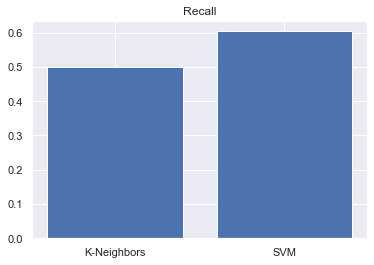

In [29]:
for i in range(2):
    print('{} : {} (Change : {})'.format(model_names[i], 
                                         round(model_gscv_recalls[i], 3), 
                                         round(model_gscv_recalls[i]-model_recalls[i], 3)
                                        )
         )
_ = plt.bar(['K-Neighbors', 'SVM'], model_gscv_recalls)
_ = plt.title('Recall')

In [30]:
test_df = df.iloc[Xtest.index].copy()
test_df['svm_pred'] = gscv_pred_svm
test_df['svm_prob'] = gscv_prob_svm[:,1]

col_check = ['player', 'season', 'age', 'allstar',
             'allstar_next', 'svm_pred', 'svm_prob']

In [31]:
test_df[(test_df.svm_pred == test_df.allstar_next)
       &(test_df.allstar_next==1)][col_check].sort_values('player').shape

(58, 7)

Trying different thresholds

In [32]:
probs = [.1, .2, .3, .4, .5]

for prob in probs:
    col_name = 'svm_pred_' + str(prob)
    test_df[col_name] = test_df.svm_prob > prob
    test_df[col_name] = test_df[col_name].astype(int)
    
    print(col_name)
    print(classification_report(test_df['allstar_next'],
                                test_df[col_name]))

svm_pred_0.1
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1243
         1.0       0.59      0.75      0.66        96

    accuracy                           0.94      1339
   macro avg       0.79      0.85      0.82      1339
weighted avg       0.95      0.94      0.95      1339

svm_pred_0.2
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1243
         1.0       0.68      0.67      0.67        96

    accuracy                           0.95      1339
   macro avg       0.83      0.82      0.82      1339
weighted avg       0.95      0.95      0.95      1339

svm_pred_0.3
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1243
         1.0       0.70      0.65      0.67        96

    accuracy                           0.96      1339
   macro avg       0.84      0.81      0.82      1339
weighted avg       0.95      0.96  

0.3 seems like the best move

## Understanding Incorrect Classifications

In [33]:
col_check = ['player', 'season', 'age', 'allstar',
             'allstar_next', 'svm_pred_0.3', 'svm_prob']

In [34]:
test_df[(test_df['svm_pred_0.3'] != test_df.allstar_next)
       ][col_check].shape

(60, 7)

60 incorrect classifications

In [35]:
test_df[(test_df['svm_pred_0.3'] != test_df.allstar_next)
        &(test_df['svm_pred_0.3'] > 0.3)
       ][col_check].sort_values('svm_prob', ascending=False)

,player,season,age,allstar,allstar_next,svm_pred_0.3,svm_prob
4264,Jerry Stackhouse,2000,26.0,1,0.0,1,0.933704
4730,Elton Brand,2005,26.0,1,0.0,1,0.925193
6038,Stephon Marbury,2000,23.0,1,0.0,1,0.916244
1360,Russell Westbrook,2012,24.0,1,0.0,1,0.915633
564,Peja Stojaković,2003,26.0,1,0.0,1,0.905569
6327,Kevin Love,2011,23.0,1,0.0,1,0.887493
1794,Isaiah Thomas,2016,27.0,1,0.0,1,0.847352
1101,Jason Kidd,2003,30.0,1,0.0,1,0.819729
2524,Baron Davis,2003,24.0,1,0.0,1,0.750905
126,Kyrie Irving,2018,26.0,1,0.0,1,0.743617


Al Horford
Allen Iverson
Amare Stoudemire: injury
Andrei Kirilenko	
Andrew Bynum: injury
Antawn Jamison: not as good as people thought?
Antoine Walker	
Baron Davis: injury
David West: Not as good as people thought
Demar Derozan: injury
Demarcus Cousins: injury
Dwyane Wade: drop off
Elton Brand: drop off / snub
Isaiah Thomas: injury
Jason Kidd: injury
Jerry Stackhouse: drop off
Josh Howard: fringe to begin, not as great a season
Jrue Holiday: injury
Kenyon Martin: drop off
Kevin Durant: injury
Kevin Love: injury
Kyrie Irving: injury
Russell Westbrook: injury
Pau Gasol: snub
Peja Stojakovic: injury
Rajon Rondo: injury
Shaq: drop off
Stephon Marbury: changed team
Tim Duncan: reduced role, drop off


In [36]:
test_df[(test_df['svm_pred_0.3'] != test_df.allstar_next)
 #       &(test_df['svm_pred_0.3'] < 0.3)
       ][col_check].sort_values(['player','svm_prob'], ascending=[True, False])

,player,season,age,allstar,allstar_next,svm_pred_0.3,svm_prob
5292,"""Amar'e Stoudemire""",2010,28.0,1,0.0,1,0.700030
2054,"""Shaquille O'Neal""",2006,34.0,1,0.0,1,0.395750
665,Al Horford,2016,30.0,0,1.0,0,0.031808
205,Allen Iverson,2009,34.0,1,1.0,0,0.192993
4092,Andrei Kirilenko,2002,21.0,0,1.0,0,0.074660
1496,Andrew Bynum,2011,24.0,1,0.0,1,0.619633
5748,Antawn Jamison,2007,31.0,1,0.0,1,0.343642
5641,Antoine Walker,2000,24.0,0,1.0,0,0.134693
2524,Baron Davis,2003,24.0,1,0.0,1,0.750905
2521,Baron Davis,2000,21.0,0,1.0,0,0.099628


In [37]:
wrong_seasons = test_df[test_df['svm_pred_0.3'] != test_df['allstar_next']
                       ].loc[:, 
                             ['season', 'age', 'tm', 'lg', 
                               'pos', 'g', 'three_att_pg', 'ft_pg',
                               'drb_pg', 'ast_pg', 'stl_pg', 
                               'blk_pg', 'pf_pg', 'height', 'href',
                               'player', 'allstar', 'allstar_next',
                               'three_pct', 'ft_pct', 'tov_100',
                               'pf_100', 'drtg', 'three_rate', 
                               'stl_pct', 'tov_pct', 'dws', 'dbpm',
                               'vorp', 'age_rank', 'g_rank', 
                               'fg_pct_rank', 'stl_pg_rank',
                               'pf_pg_rank', 'three_pct_rank', 
                               'ft_pct_rank', 'tov_100_rank',
                               'pf_100_rank', 'drtg_rank', 
                               'tov_pct_rank', 'dws_rank', 'dbpm_rank',
                    #           'svm_pred', 'svm_prob', 'svm_pred_0.3'
                             ]
                            ]
wrong_followup = df.loc[wrong_seasons.index+1]

In [38]:
wrong_followup.shape, wrong_seasons.shape

((60, 42), (60, 42))

In [39]:
wrong_seasons.describe()

,season,age,g,three_att_pg,ft_pg,drb_pg,ast_pg,stl_pg,blk_pg,pf_pg,...,stl_pg_rank,pf_pg_rank,three_pct_rank,ft_pct_rank,tov_100_rank,pf_100_rank,drtg_rank,tov_pct_rank,dws_rank,dbpm_rank
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2008.583333,26.833333,69.466667,2.658333,3.891667,5.253333,4.191667,1.055000,0.951667,2.501667,...,231.258333,222.825000,178.516667,204.216667,239.525000,101.466667,126.508333,159.233333,253.658333,179.225000
std,5.696540,4.647458,14.202490,2.521251,1.581384,2.148351,2.533925,0.454143,0.765903,0.577397,...,79.396105,79.693578,85.991671,89.176143,86.558515,75.968318,97.846797,91.312811,89.317444,107.024408
min,2000.000000,20.000000,28.000000,0.000000,1.300000,2.100000,1.000000,0.200000,0.100000,1.500000,...,11.000000,50.000000,25.500000,3.000000,17.000000,5.500000,1.000000,3.500000,8.000000,7.000000
25%,2003.000000,23.000000,64.750000,0.175000,2.875000,3.400000,2.075000,0.700000,0.375000,2.075000,...,176.625000,169.500000,117.250000,140.500000,177.750000,40.375000,41.875000,88.375000,221.750000,93.000000
50%,2008.500000,26.000000,74.500000,2.650000,3.500000,5.100000,3.350000,1.000000,0.650000,2.500000,...,241.500000,234.500000,185.250000,212.750000,270.250000,83.250000,114.750000,159.000000,286.500000,185.000000
75%,2013.000000,30.000000,80.000000,4.425000,4.825000,6.675000,5.950000,1.300000,1.425000,2.800000,...,294.000000,284.875000,239.250000,264.250000,311.500000,137.000000,178.250000,231.500000,314.500000,287.500000
max,2018.000000,39.000000,82.000000,8.700000,8.300000,10.700000,11.100000,2.400000,2.700000,3.800000,...,341.000000,354.000000,327.500000,350.500000,353.000000,311.500000,325.000000,335.000000,348.000000,343.000000


In [40]:
wrong_followup.describe()

,season,age,g,three_att_pg,ft_pg,drb_pg,ast_pg,stl_pg,blk_pg,pf_pg,...,stl_pg_rank,pf_pg_rank,three_pct_rank,ft_pct_rank,tov_100_rank,pf_100_rank,drtg_rank,tov_pct_rank,dws_rank,dbpm_rank
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.00000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2009.116667,27.583333,66.950000,2.530000,3.591667,4.966667,4.031667,1.048333,0.870000,2.420000,...,226.900000,213.916667,158.183333,187.091667,237.00000,109.250000,131.925000,164.941667,236.650000,182.566667
std,5.781595,4.773840,17.042743,2.285422,1.591960,2.053163,2.641936,0.484503,0.744995,0.572772,...,92.135898,83.432870,95.679238,84.799339,85.93765,81.015614,102.045513,98.009862,92.642071,110.878024
min,2000.000000,20.000000,18.000000,0.000000,0.400000,1.600000,0.300000,0.200000,0.100000,1.200000,...,8.500000,26.500000,22.000000,7.000000,9.00000,3.000000,3.500000,2.500000,10.000000,1.000000
25%,2004.000000,23.750000,60.000000,0.200000,2.600000,3.275000,2.175000,0.675000,0.300000,2.000000,...,167.500000,164.625000,84.000000,140.750000,190.75000,42.750000,37.750000,100.250000,182.500000,72.375000
50%,2009.000000,27.000000,74.500000,2.350000,3.700000,4.950000,3.150000,1.000000,0.550000,2.350000,...,247.750000,220.000000,146.500000,178.250000,255.25000,85.250000,108.000000,141.750000,252.500000,186.500000
75%,2013.250000,31.000000,80.000000,3.925000,4.425000,6.525000,5.375000,1.325000,1.200000,2.900000,...,302.500000,281.000000,241.125000,258.375000,306.25000,155.625000,221.000000,246.625000,314.125000,288.000000
max,2018.000000,40.000000,82.000000,8.000000,7.500000,10.400000,11.000000,2.300000,2.800000,3.700000,...,335.000000,358.000000,336.000000,338.000000,352.00000,344.000000,347.000000,357.000000,363.500000,361.500000


In [41]:
wrong_followup.describe().iloc[:, :10] - wrong_seasons.describe().iloc[:, :10]

,season,age,g,three_att_pg,ft_pg,drb_pg,ast_pg,stl_pg,blk_pg,pf_pg
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.533333,0.750000,-2.516667,-0.128333,-0.300000,-0.286667,-0.160000,-0.006667,-0.081667,-0.081667
std,0.085055,0.126382,2.840252,-0.235830,0.010575,-0.095188,0.108011,0.030360,-0.020908,-0.004625
min,0.000000,0.000000,-10.000000,0.000000,-0.900000,-0.500000,-0.700000,0.000000,0.000000,-0.300000
25%,1.000000,0.750000,-4.750000,0.025000,-0.275000,-0.125000,0.100000,-0.025000,-0.075000,-0.075000
50%,0.500000,1.000000,0.000000,-0.300000,0.200000,-0.150000,-0.200000,0.000000,-0.100000,-0.150000
75%,0.250000,1.000000,0.000000,-0.500000,-0.400000,-0.150000,-0.575000,0.025000,-0.225000,0.100000
max,0.000000,1.000000,0.000000,-0.700000,-0.800000,-0.300000,-0.100000,-0.100000,0.100000,-0.100000


In [42]:
wrong_followup.describe().iloc[:, 10:20] - wrong_seasons.describe().iloc[:, 10:20]

,height,allstar,allstar_next,three_pct,ft_pct,tov_100,pf_100,drtg,three_rate,stl_pct
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.133333,0.050000,-0.266667,-0.016867,-0.010517,-0.073333,0.076667,0.750000,0.008833,0.056667
std,-0.121782,-0.002527,-0.037593,0.045195,-0.007614,0.035979,0.052478,-0.590714,0.010475,0.110567
min,0.000000,0.000000,0.000000,0.000000,0.060000,-0.200000,-0.200000,4.000000,0.000000,0.100000
25%,0.000000,0.000000,0.000000,-0.045000,-0.003250,0.025000,0.000000,0.000000,0.000250,-0.025000
50%,0.000000,0.500000,-1.000000,-0.024500,-0.022500,-0.350000,0.050000,-0.500000,-0.006500,0.100000
75%,0.000000,0.000000,0.000000,-0.006250,-0.006000,-0.225000,0.125000,1.000000,-0.003000,0.275000
max,0.000000,0.000000,0.000000,0.561000,0.019000,-0.400000,0.200000,0.000000,0.087000,0.100000


In [43]:
wrong_followup.describe().iloc[:, 20:30] - wrong_seasons.describe().iloc[:, 20:30]

,tov_pct,dws,dbpm,vorp,age_rank,g_rank,fg_pct_rank,stl_pg_rank,pf_pg_rank,three_pct_rank
count,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.025000,-0.198333,0.01500,-0.283333,16.875000,-14.566667,-19.033333,-4.358333,-8.908333,-20.333333
std,0.245843,0.102409,0.09166,0.300688,-1.387107,11.035872,17.038407,12.739793,3.739292,9.687567
min,-1.700000,0.100000,-1.80000,-0.300000,4.000000,-2.000000,-24.000000,-2.500000,-23.500000,-3.500000
25%,-0.350000,-0.500000,-0.20000,-0.750000,12.625000,-57.875000,-22.125000,-9.125000,-4.875000,-33.250000
50%,0.000000,-0.500000,0.00000,-0.050000,23.250000,-4.500000,-20.500000,6.250000,-14.500000,-38.750000
75%,0.525000,0.075000,-0.12500,-0.100000,20.125000,6.625000,-1.125000,8.500000,-3.875000,1.875000
max,-0.800000,0.200000,0.00000,0.400000,14.500000,-2.000000,5.000000,-6.000000,4.000000,8.500000


In [44]:
wrong_followup.describe().iloc[:, 30:] - wrong_seasons.describe().iloc[:, 30:]

,ft_pct_rank,tov_100_rank,pf_100_rank,drtg_rank,tov_pct_rank,dws_rank,dbpm_rank
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,-17.125000,-2.525000,7.783333,5.416667,5.708333,-17.008333,3.341667
std,-4.376804,-0.620865,5.047296,4.198716,6.697051,3.324627,3.853616
min,4.000000,-8.000000,-2.500000,2.500000,-1.000000,2.000000,-6.000000
25%,0.250000,13.000000,2.375000,-4.125000,11.875000,-39.250000,-20.625000
50%,-34.500000,-15.000000,2.000000,-6.750000,-17.250000,-34.000000,1.500000
75%,-5.875000,-5.250000,18.625000,42.750000,15.125000,-0.375000,0.500000
max,-12.500000,-1.000000,32.500000,22.000000,22.000000,15.500000,18.500000


Better: ft_pct_rank, tov_100_rank, drtg_rank, dws_rank
Worse: pf_100_rank, 



# Snubs or Dropoffs?

In [45]:
df[(df.season==2001) & (df.allstar==1)][['player', 'season', 'allstar']]

,player,season,allstar
197,Allen Iverson,2001,1
490,Dikembe Mutombo,2001,1
498,Shareef Abdur-Rahim,2001,1
562,Peja Stojaković,2001,1
981,Chris Webber,2001,1
988,Tim Duncan,2001,1
1099,Jason Kidd,2001,1
1434,Steve Nash,2001,1
1664,Paul Pierce,2001,1
2049,"""Shaquille O'Neal""",2001,1


In [46]:
test_df[(test_df['svm_pred_0.3'] != test_df.allstar_next)
        &(test_df['allstar_next']==0)
       ][col_check].sort_values(['season', 'svm_prob'])

,player,season,age,allstar,allstar_next,svm_pred_0.3,svm_prob
6038,Stephon Marbury,2000,23.0,1,0.0,1,0.916244
4264,Jerry Stackhouse,2000,26.0,1,0.0,1,0.933704
4726,Elton Brand,2001,22.0,1,0.0,1,0.682978
1575,Kenyon Martin,2003,26.0,1,0.0,1,0.557510
2524,Baron Davis,2003,24.0,1,0.0,1,0.750905
1101,Jason Kidd,2003,30.0,1,0.0,1,0.819729
564,Peja Stojaković,2003,26.0,1,0.0,1,0.905569
4730,Elton Brand,2005,26.0,1,0.0,1,0.925193
2054,"""Shaquille O'Neal""",2006,34.0,1,0.0,1,0.395750
613,Josh Howard,2006,26.0,1,0.0,1,0.617482


In [47]:
snub = [6316]
dropoff = []

# Predict 1st time allstars

In [48]:
df['first_time_as'] = 0
for player in df.player.unique():
    player_df = df[(df.player == player)
                        &(df.allstar == 1)]
    if player_df.shape[0] != 0:
        first_year = player_df.season.min()
        first_index = df[(df.player == player)
               &(df.season == first_year)].index
        df.iloc[first_index, -1] = 1
    else:
        print('{} was never an allstar'.format(player))

Brian Skinner was never an allstar
Bruno Caboclo was never an allstar
Ryan Kelly was never an allstar
Spencer Hawes was never an allstar
Rodney McGruder was never an allstar
Sasha Vujačić was never an allstar
Brian Cook was never an allstar
Chris Duhon was never an allstar
Steve Smith was never an allstar
Devean George was never an allstar
Quinton Ross was never an allstar
Rodney White was never an allstar
Nolan Smith was never an allstar
Scot Pollard was never an allstar
Harry Giles was never an allstar
Rod Strickland was never an allstar
Dan Dickau was never an allstar
Kenneth Faried was never an allstar
Brandon Ingram was never an allstar
Wang Zhizhi was never an allstar
Lance Stephenson was never an allstar
Daniel Gibson was never an allstar
Kerry Kittles was never an allstar
Robin Lopez was never an allstar
Stephen Jackson was never an allstar
Diante Garrett was never an allstar
Spencer Dinwiddie was never an allstar
Andrés Nocioni was never an allstar
Anderson Varejão was never a

Darvin Ham was never an allstar
Gary Harris was never an allstar
Pape Sow was never an allstar
Bryn Forbes was never an allstar
Hollis Thompson was never an allstar
Tony Wroten was never an allstar
Abdel Nader was never an allstar
Jeffery Taylor was never an allstar
Tony Allen was never an allstar
Andrew Harrison was never an allstar
Semi Ojeleye was never an allstar
Jason Smith was never an allstar
Moochie Norris was never an allstar
Meyers Leonard was never an allstar
Jodie Meeks was never an allstar
Mardy Collins was never an allstar
Royal Ivey was never an allstar
Nate Robinson was never an allstar
Mark Jackson was never an allstar
Lee Nailon was never an allstar
Kyle Singler was never an allstar
Ervin Johnson was never an allstar
Mitchell Butler was never an allstar
Jimmer Fredette was never an allstar
Rick Fox was never an allstar
Ike Diogu was never an allstar
Jay Williams was never an allstar
Jeremy Pargo was never an allstar
Jabari Smith was never an allstar
Renaldo Balkman wa

Lawrence Funderburke was never an allstar
Linas Kleiza was never an allstar
John Henson was never an allstar
Walter McCarty was never an allstar
Eric Snow was never an allstar
Otis Thorpe was never an allstar
Brendan Haywood was never an allstar
A.J. Price was never an allstar
Alan Anderson was never an allstar
Mike Bibby was never an allstar
Chris Porter was never an allstar
James Johnson was never an allstar
Derrick Favors was never an allstar
Tyreke Evans was never an allstar
Tony Massenburg was never an allstar
Nicolás Brussino was never an allstar
Charlie Villanueva was never an allstar
Doug Overton was never an allstar
Jawad Williams was never an allstar
Jeremy Lamb was never an allstar
Ivan Johnson was never an allstar
"Kyle O'Quinn" was never an allstar
Mario Hezonja was never an allstar
Malik Beasley was never an allstar
Cuttino Mobley was never an allstar
Austin Rivers was never an allstar
Maxi Kleber was never an allstar
Nik Stauskas was never an allstar
Shawn Kemp was never

Popeye Jones was never an allstar
DeMarre Carroll was never an allstar
Aaron Holiday was never an allstar
Arvydas Sabonis was never an allstar
Nikoloz Tskitishvili was never an allstar
Michael Kidd-Gilchrist was never an allstar
John Thomas was never an allstar
Boštjan Nachbar was never an allstar
Chris Gatling was never an allstar
Malik Allen was never an allstar
Robert Pack was never an allstar
Mark Blount was never an allstar
Fred Hoiberg was never an allstar
Stephen Graham was never an allstar
Ed Davis was never an allstar
Domantas Sabonis was never an allstar
Chris Andersen was never an allstar
Jason Kapono was never an allstar
Danuel House was never an allstar
Eric Moreland was never an allstar
Alex Len was never an allstar
Drew Gooden was never an allstar
Daniel Theis was never an allstar
Jeff McInnis was never an allstar
Juan Hernangómez was never an allstar
Ronald Dupree was never an allstar
Lou Amundson was never an allstar
Henry Walker was never an allstar
MarShon Brooks was

In [49]:
first_allstar_seasons = df[df.first_time_as == 1].index
preceding_seasons= first_allstar_seasons-1
seasons_in_test = set(preceding_seasons).intersection(set(test_df.index))
seasons_in_test_list = [i for i in seasons_in_test]

In [50]:
test_df.loc[seasons_in_test_list][['player', 'season', 
                                   'svm_pred_0.3', 'allstar_next']
                                 ].sort_values('svm_pred_0.3', 
                                               ascending=False)

,player,season,svm_pred_0.3,allstar_next
2358,Dirk Nowitzki,2000,1,1.0
457,DeMarcus Cousins,2013,1,1.0
3971,Grant Hill,2002,0,1.0
4053,Wally Szczerbiak,2000,0,1.0
3198,Chris Bosh,2004,0,1.0
4092,Andrei Kirilenko,2002,0,1.0
761,Joe Johnson,2005,0,1.0
4725,Elton Brand,2000,0,1.0
1653,Damian Lillard,2012,0,1.0
1268,Nikola Vučević,2017,0,1.0


In [51]:
2/22

0.09090909090909091

## New allstars


In [52]:
test_df

,season,age,tm,lg,pos,g,three_att_pg,ft_pg,drb_pg,ast_pg,...,tov_pct_rank,dws_rank,dbpm_rank,svm_pred,svm_prob,svm_pred_0.1,svm_pred_0.2,svm_pred_0.3,svm_pred_0.4,svm_pred_0.5
4867,2009,29.0,HOU,NBA,PF,82.0,0.1,2.5,6.5,2.1,...,139.0,278.5,152.5,0.0,0.020333,0,0,0,0,0
2612,2005,25.0,TOR,NBA,PF,78.0,3.1,0.8,2.5,0.7,...,2.0,37.5,103.5,0.0,0.033976,0,0,0,0,0
4043,2018,24.0,CHI,NBA,PG,81.0,2.7,1.1,2.4,3.3,...,202.0,104.0,189.0,0.0,0.019892,0,0,0,0,0
2517,2004,28.0,MEM,NBA,SG,69.0,1.5,2.0,2.6,1.2,...,89.0,266.0,295.0,0.0,0.031098,0,0,0,0,0
6220,2018,22.0,MIN,NBA,PG,68.0,1.9,0.9,1.6,4.8,...,62.5,104.0,221.0,0.0,0.029806,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,2011,30.0,NJN,NBA,SF,51.0,2.8,0.2,1.8,0.8,...,47.0,11.0,117.0,0.0,0.005379,0,0,0,0,0
2757,2009,30.0,POR,NBA,C,30.0,0.0,1.1,5.5,0.3,...,329.0,137.0,302.5,0.0,0.014311,0,0,0,0,0
4746,2002,26.0,MIN,NBA,PF,82.0,0.9,4.6,10.5,6.0,...,90.5,310.0,304.5,1.0,0.940323,1,1,1,1,1
4827,2001,39.0,UTA,NBA,PG,82.0,1.0,3.4,2.5,8.2,...,287.5,250.0,282.5,0.0,0.037357,0,0,0,0,0


In [53]:
test_df[(test_df['svm_pred_0.3'] == test_df.allstar_next)
       &(test_df.allstar_next == 1)
       &(test_df.allstar==0)
       ][col_check].sort_values('player')

,player,season,age,allstar,allstar_next,svm_pred_0.3,svm_prob
457,DeMarcus Cousins,2013,23.0,0,1.0,1,0.351980
2358,Dirk Nowitzki,2000,22.0,0,1.0,1,0.305588


In [54]:
test_df[(test_df.allstar==0)
       &(test_df.allstar_next==1)
       &(test_df.allstar_next!=test_df['svm_pred_0.3'])
      # &(test_df.age < 25)
       ][col_check]

,player,season,age,allstar,allstar_next,svm_pred_0.3,svm_prob
1441,Steve Nash,2008,34.0,0,1.0,0,0.076722
3971,Grant Hill,2002,30.0,0,1.0,0,0.199559
5059,Brandon Roy,2006,22.0,0,1.0,0,0.083617
4239,Joakim Noah,2011,26.0,0,1.0,0,0.044636
665,Al Horford,2016,30.0,0,1.0,0,0.031808
1669,Paul Pierce,2006,29.0,0,1.0,0,0.112978
761,Joe Johnson,2005,24.0,0,1.0,0,0.065233
4626,Mehmet Okur,2005,26.0,0,1.0,0,0.069670
6308,DeMar DeRozan,2014,25.0,0,1.0,0,0.081987
2375,Dirk Nowitzki,2017,39.0,0,1.0,0,0.012864


# Looking at validation set
Now I will test my validation set and see how well both the fitted models perform
### Logistic Regression

In [55]:
val_svm = gscv_svm.predict(Xval)
val_prob_svm = gscv_svm.predict_proba(Xval)[:,1]
print(confusion_matrix(yval,val_svm))
print(classification_report(yval,val_svm))

[[525   9]
 [ 18  23]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       534
         1.0       0.72      0.56      0.63        41

    accuracy                           0.95       575
   macro avg       0.84      0.77      0.80       575
weighted avg       0.95      0.95      0.95       575



# 2020 Predictions

In [73]:
df_2019 = df[df.season==2019].copy()
df_rest = df[df.season!=2019].copy()

In [74]:
df_2019.reset_index(drop=True, inplace=True)

In [75]:
allstars2020 = ['Anthony Davis', 'James Harden', 'Luka Dončić', 'LeBron James',
 'Devin Booker', 'Damian Lillard', 'Nikola Jokić', 'Ben Simmons',
 'Domantas Sabonis', 'Jayson Tatum', 'Russell Westbrook', 
 'Giannis Antetokounmpo', 'Joel Embiid', 'Pascal Siakam', 
 'Kemba Walker', 'Trae Young', 'Bam Adebayo', 'Brandon Ingram',
 'Donovan Mitchell', 'Jimmy Butler', 'Rudy Gobert', 'Kyle Lowry',
 'Khris Middleton'
]

In [82]:
all_list = []
for i, row in df_2019.iterrows():
    if row['player'] in allstars2020:
        all_list.append(i)

In [88]:
df_2019.iloc[all_list, 16] = 1

In [91]:
# adjust for 82 game season
df_2019.reset_index(drop=True)
df_2019.shape

(315, 42)

In [92]:
int_df = df_2019.select_dtypes(exclude=object).copy()
int_df.drop('season', axis=1, inplace=True)
print(int_df[int_df['allstar_next']==0].shape,int_df[int_df['allstar_next']==1].shape)

features = int_df.loc[:, int_df.columns != 'allstar_next']

(314, 36) (1, 36)


### SVM

In [95]:
prob_svm2020 = gscv_svm.predict_proba(features)[:,1]

In [96]:
df_2019['svm_prob'] = prob_svm2020.copy()

In [112]:
col_check = ['player', 'season', 'age', 'allstar', 'svm_prob']
df_2019[df_2019['svm_prob'] > 0.3
       ][col_check].sort_values('svm_prob',
                                ascending=False
                               ).player

203               Trae Young
38     Giannis Antetokounmpo
204            Anthony Davis
199              Luka Dončić
55               Joel Embiid
78            Damian Lillard
22              Jimmy Butler
213             Jayson Tatum
50               Ben Simmons
56              LeBron James
2             Brandon Ingram
66         Russell Westbrook
93              Devin Booker
266         Donovan Mitchell
234             Nikola Jokić
208            Pascal Siakam
129             James Harden
313          Khris Middleton
219             Kemba Walker
238         Domantas Sabonis
Name: player, dtype: object

In [109]:
df_2019[(df_2019.allstar == 1)
       &(df_2019.svm_prob < 0.3)][col_check]

,player,season,age,allstar,svm_prob
12,Rudy Gobert,2019,27.0,1,0.098314
21,Kyle Lowry,2019,33.0,1,0.120194
163,Chris Paul,2019,34.0,1,0.207499
212,Bam Adebayo,2019,22.0,1,0.293761


In [76]:
df_2019.columns

Index(['season', 'age', 'tm', 'lg', 'pos', 'g', 'three_att_pg', 'ft_pg',
       'drb_pg', 'ast_pg', 'stl_pg', 'blk_pg', 'pf_pg', 'height', 'href',
       'player', 'allstar', 'allstar_next', 'three_pct', 'ft_pct', 'tov_100',
       'pf_100', 'drtg', 'three_rate', 'stl_pct', 'tov_pct', 'dws', 'dbpm',
       'vorp', 'age_rank', 'g_rank', 'fg_pct_rank', 'stl_pg_rank',
       'pf_pg_rank', 'three_pct_rank', 'ft_pct_rank', 'tov_100_rank',
       'pf_100_rank', 'drtg_rank', 'tov_pct_rank', 'dws_rank', 'dbpm_rank',
       'svm_prob'],
      dtype='object')